**Introduction**  
The goal of this project is to determine whether a tweet that was sent out into the world is about a real disaster or not. The training set has 7613 samples and 5 features: id, keyword, location, text and target. The test set has 3263 samples and 4 features: id, keyword, location and text. The goal is to be able to accurately predict the target.

In [1]:
#!pip install keras-tuner

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, Embedding, LSTM
from keras.preprocessing.sequence import pad_sequences
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

C:\Users\Kevin\AppData\Local\Temp\ipykernel_11180\4146639412.py:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kevin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
path_test = 'Data/disaster_tweets_test.csv'
path_train = 'Data/disaster_tweets_train.csv'
train_df = pd.read_csv(path_train)
test_df = pd.read_csv(path_test)

In [4]:
print(train_df.head())
print(f'Training Set Shape: {train_df.shape}')
print(f'Test Set Shape: {test_df.shape}')
print(train_df.isnull().sum())
print(test_df.isnull().sum())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
Training Set Shape: (7613, 5)
Test Set Shape: (3263, 4)
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword       26
location    1105
text           0
dtype: int64


**Exploratory Data Analysis (EDA)**  
To clean the data I'm going to use some regex's to remove urls, html tags, punctuation and numbers, set all the words to lowercase and remove whitespace. The main plan of analysis is primarily focus on the text, the other features don't seem to provide as much information and contain a lot of missing values.

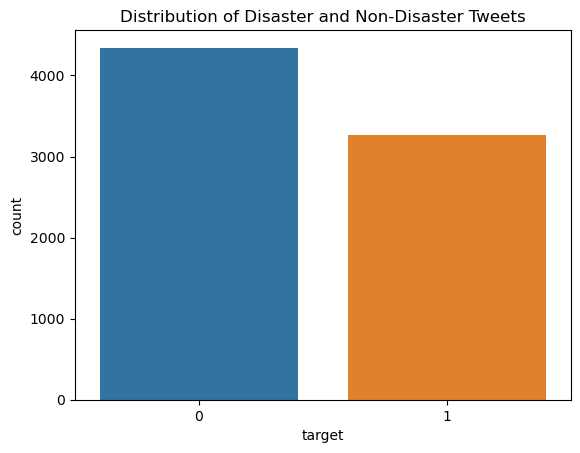

In [5]:
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Disaster and Non-Disaster Tweets')
plt.show()

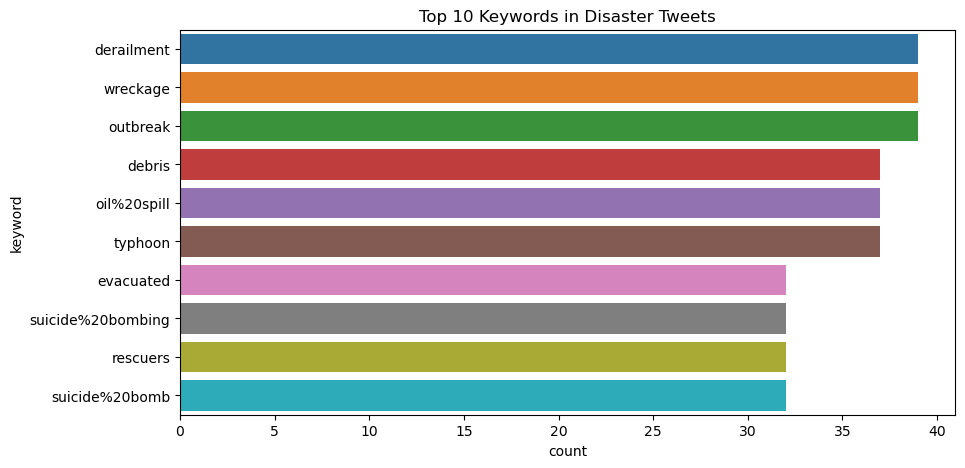

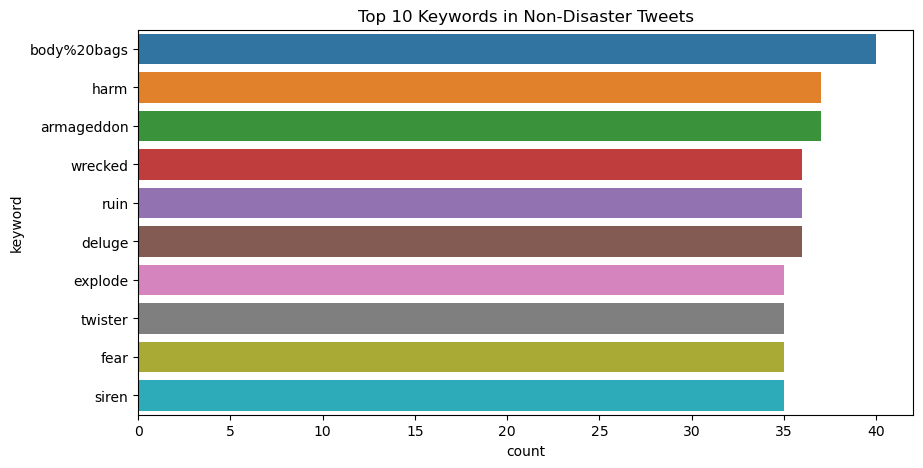

In [6]:
plt.figure(figsize=(10, 5))
sns.countplot(y='keyword', data=train_df[train_df['target'] == 1], order = train_df[train_df['target'] == 1]['keyword'].value_counts().index[:10])
plt.title('Top 10 Keywords in Disaster Tweets')
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(y='keyword', data=train_df[train_df['target'] == 0], order = train_df[train_df['target'] == 0]['keyword'].value_counts().index[:10])
plt.title('Top 10 Keywords in Non-Disaster Tweets')
plt.show()

C:\Users\Kevin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


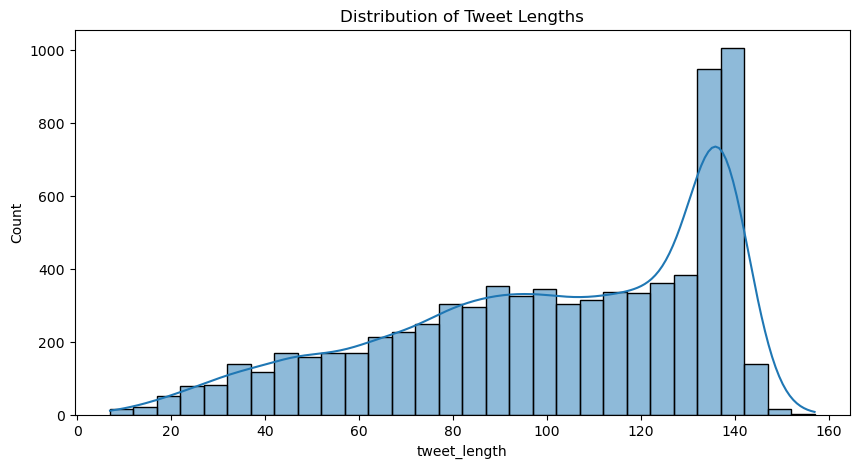

In [7]:
train_df['tweet_length'] = train_df['text'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(train_df['tweet_length'], bins=30, kde=True)
plt.title('Distribution of Tweet Lengths')
plt.show()

In [8]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove punctuation and numbers
    text = text.lower()  # Lowercase
    text = text.strip()  # Remove leading/trailing whitespace
    return text

train_df['text_clean'] = train_df['text'].apply(clean_text)

**Models and Analysis**  
The models I'm going to use are Word2Vec and LSTM. Originally I had considered using TF-IDF, but this would be semi incompatible with LSTM because LSTM is proficient at capturing context and maintaining the sequential nature of text. Whereas TF-IDF would vectorize the information making it more high-dimensional and more sparse where tweets are already limited in their text. I also chose to run hyperparameter tuning in attempt to get the best model possible with this set up.

In [9]:
def tweet_to_sequence(tweet, word_index, max_length):
    return [word_index.get(word, 0) for word in tweet[:max_length]]

In [10]:
class MyHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(Embedding(input_dim=len(word_index) + 1,
                            output_dim=100,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False))
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32)))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

In [11]:
train_df['tokens'] = train_df['text_clean'].apply(lambda x: word_tokenize(x))
word2vec_model = Word2Vec(sentences=train_df['tokens'], vector_size=100, window=5, min_count=1, workers=4)
word_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key, 1)}
max_length = 20
sequences = [tweet_to_sequence(tweet, word_index, max_length) for tweet in train_df['tokens']]
X = pad_sequences(sequences, maxlen=max_length, padding='post')

embedding_matrix = np.zeros((len(word_index) + 1, word2vec_model.vector_size))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [12]:
hypermodel = MyHyperModel(input_shape=(max_length,), num_classes=2)
y = train_df['target'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hparam_tuning'
)

tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_val, y_val))

Reloading Tuner from my_dir\hparam_tuning\tuner0.json
Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [13]:
tuner.results_summary(num_trials=10)

Results summary
Results in my_dir\hparam_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
units: 384
dropout: 0.0
learning_rate: 0.00010188905884308546
Score: 0.7143794894218445

Trial 01 summary
Hyperparameters:
units: 32
dropout: 0.0
learning_rate: 0.0003004766864156742
Score: 0.7091267108917236

Trial 07 summary
Hyperparameters:
units: 384
dropout: 0.2
learning_rate: 0.0003219193613684285
Score: 0.7078135013580322

Trial 09 summary
Hyperparameters:
units: 64
dropout: 0.1
learning_rate: 0.0004268512742649292
Score: 0.7065003514289856

Trial 02 summary
Hyperparameters:
units: 320
dropout: 0.4
learning_rate: 0.0001358890865258992
Score: 0.70124751329422

Trial 04 summary
Hyperparameters:
units: 224
dropout: 0.1
learning_rate: 0.002493122474929987
Score: 0.6999343633651733

Trial 08 summary
Hyperparameters:
units: 480
dropout: 0.0
learning_rate: 0.001187577274462532
Score: 0.6894287467002869

Trial 00 summary
Hyperparameter

**Results and Analysis**  
| Trial | Units | Dropout | Learning Rate | Score |
|:------|:------|:--------|:--------------|:------|
| 06    | 384   | 0.0     | 0.000101889   | 0.7143794894218445 |
| 01    | 32    | 0.0     | 0.000300476   | 0.7091267108917236 |
| 07    | 384   | 0.2     | 0.000321919   | 0.7078135013580322 |
| 09    | 64    | 0.1     | 0.000426851   | 0.7065003514289856 |
| 02    | 320   | 0.4     | 0.000135889   | 0.70124751329422   |
| 04    | 224   | 0.1     | 0.002493122   | 0.6999343633651733 |
| 08    | 480   | 0.0     | 0.001187577   | 0.6894287467002869 |
| 00    | 160   | 0.1     | 0.003557595   | 0.6776099801063538 |
| 05    | 416   | 0.2     | 0.001165682   | 0.6618515849113464 |
| 03    | 512   | 0.1     | 0.006851781   | 0.5791201591491699 |

After running the hyperparameter tunning, we can see the best model ended up being trial 6. This model had no dropout and a very low learning rate. This shows us that a complex model without regularization may be the most optimal choice within the search space.

**Conclusion**  
The hyperparameter tuning proceess was very helpful in gaining insight into the model and its behavior. I think moving forward experimenting with different configurations on the model could yield something good. As well I think one thing that could have benefited this experiment is possibly incorporating more sophisticated text preprocessing and possibly other features.

RESOURCES:  
https://regex101.com/library?orderBy=MOST_POINTS&page=316  
https://www.tensorflow.org/text/tutorials/word2vec